In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os

In [2]:
def classifying_data (training_data_class,unique,k):
    n = len(training_data_class)
    index_class = [i for i in range(n) if training_data_class[i] == unique]
    nc = len(index_class)
    xc =np.array(py_10[:,index_class])    
    xc_mean = np.reshape(np.mean(xc, axis = 1),(k,1))  
    return index_class,nc,xc,xc_mean 

In [3]:
def Sort_eigen_vector(val,vec):
    index = np.argsort(val)[::-1]
    val = val[index]
    vec = vec[:,index]
    return val, vec

In [4]:
def Accuracy(label_true, label_pred):
    label_true = np.reshape(np.array(label_true ),(len(label_true ),1))
    label_pred = np.reshape(np.array(label_pred ),(len(label_pred ),1))
    n_p = label_pred.shape[0]
    print("Number of prediction: ",n_p)
    cp = np.sum(np.abs(label_pred-label_true))
    print("Number of wrong predictions: ",cp)
    print("Accuracy: ",(n_p-cp)*100/n_p)

In [5]:
def FisherRatio(Sb,Sw,W):
    J = (W.T@Sb@W)/(W.T@Sw@W)
    return J

In [6]:
# Loading Training data
list_train = os.listdir(r".\emotion_classification\\train")
training_data = np.array([plt.imread(r'.\emotion_classification\\train\\' + x).flatten(order='F') for x in list_train]).T
D,n = training_data.shape[0],training_data.shape[1]
training_data_class= []
for x in list_train:
    if 'happy' in x:
        training_data_class.append(1)
    else:
        training_data_class.append(0)
tr_mean = np.reshape(np.mean(training_data, axis = 1),(D,1))

In [7]:
# Loading Testing data
list_test = os.listdir(r".\emotion_classification\\test")
testing_data = np.array([plt.imread(r'.\emotion_classification\\test\\' + x).flatten(order='F') for x in list_test]).T
testing_data_class= []
for x in list_test:
    if 'happy' in x:
        testing_data_class.append(1)
    else:
        testing_data_class.append(0)

In [8]:
# Fitting the model based on training data
# Centering
X = training_data - tr_mean
# Finding eigen value and eigen vectors of sample space
S_x = (1/(n))*(X.T@X)
x_val,x_vec = np.linalg.eigh(S_x)
x_val,x_vec = Sort_eigen_vector(x_val, x_vec)
# Arranging eigen values in descending order and arraning corresponding eigen vectors for PCA
U = (X @ x_vec) / np.sqrt(x_val*n)
# Parameter to determine principal component
k = 18
py_10 = U[:,:k].T@(X)

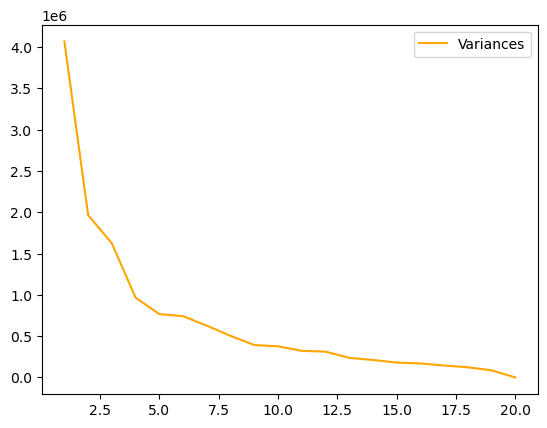

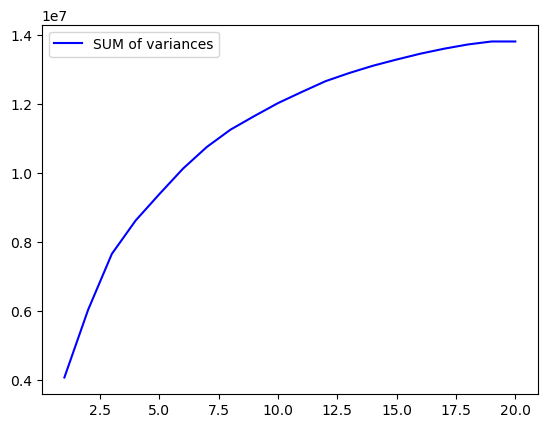

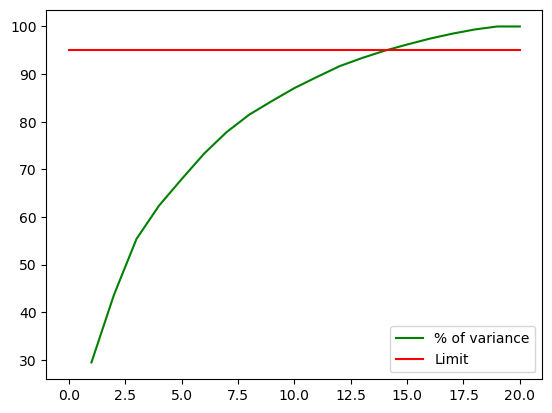

In [9]:
# this section is just to see eigen value distribution 
# Distribution of variance along dimensions
x_axis = np.linspace(1,x_val.size,x_val.size)
plt.plot(x_axis,x_val,color='orange',label = "Variances")
plt.legend()
plt.show()
x_val_sum = np.array([0]*x_val.size)
x_val_sum[0] = x_val[0]
for i in range(1,x_val.size):
    x_val_sum[i] += x_val_sum[i-1] + x_val[i] 
plt.plot(x_axis,x_val_sum,color='blue',label = "SUM of variances")
plt.legend()
plt.show()
x_val_p = x_val_sum*100/x_val_sum[-1]
plt.plot(x_axis,x_val_p,color='green',label = "% of variance")
y_th = np.array([95]*5)
x_th = np.linspace(0,20,5)
plt.plot(x_th,y_th,color='red',label = "Limit")
plt.legend()

In [10]:
# LDA performing dimensionality reduction to dimension 1
d=1
# Finding indexes of both classes
index_class1,n1,x1,x1_mean = classifying_data(training_data_class,1,k)
index_class2,n2,x2,x2_mean = classifying_data(training_data_class,0,k)
# Between class variance
S_b = (x1_mean-x2_mean)@((x1_mean-x2_mean).T)
# Within class variance
S_w = ((x1-x1_mean)@(x1 - x1_mean).T)/n1 +  ((x2-x2_mean)@(x2 - x2_mean).T)/n2

# Calculating the eigen value and eigen vector of S_w inverse*S_b 
lda_val , lda_vec = np.linalg.eig(np.linalg.inv(S_w)@S_b)
# Sorting the eigen vector accoring to eigen value in descending value
lda_val,lda_vec = Sort_eigen_vector(lda_val, lda_vec)
# Selecting largest d eigen value and forming projector 
W_projector = lda_vec[:,:d]
W_projector = np.linalg.inv(S_w)@(x2_mean-x1_mean)         # This step can be use, it reduces computation 
W_projector = W_projector/np.linalg.norm(W_projector, 2)
# Final projection of the data in lower dimension after LDA d =1
lda_y1 = W_projector.T@x1
lda_y2 = W_projector.T@x2
var1 = np.sum(lda_y1)
var2 = np.sum(lda_y2)
threshold =(var1+var2)/(lda_y1.shape[1]+lda_y2.shape[1])
#threshold = (var1+var2)/2

In [11]:
# predicting for  the training data
# Reducing dimension by Applying PCA 
py_tr = U[:,:k].T@(X)
    
# Final data in lower dimension after LDA d =1
lda_ytr = W_projector.T@py_tr
c1tr=[]
c2tr=[]
class_train = []
ltr = (lda_ytr.shape[1])
for i in range(ltr):
    if lda_ytr[0][i] > threshold:
        c2tr.append(lda_ytr[0][i])
        class_train.append(0)
    else:
        c1tr.append(lda_ytr[0][i])
        class_train.append(1)

In [12]:
print(threshold)

9.094947017729283e-14


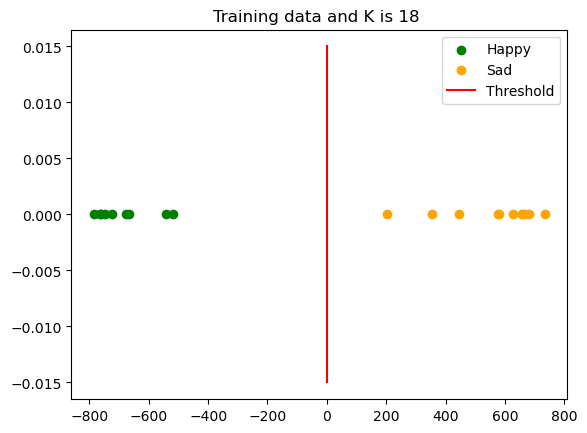

In [13]:
# Training data result plots
y1_axis = (np.array([0]*(lda_y1.shape[1])))
y2_axis = (np.array([0]*(lda_y2.shape[1])))
thr_line = np.array([threshold]*5)
y3_axis = np.linspace(-0.015,0.015,5)
plt.scatter(lda_y1,y1_axis,color='green',label = 'Happy')
plt.scatter(lda_y2,y2_axis,color='orange', label ='Sad')
plt.plot(thr_line,y3_axis,color='red',label = "Threshold")
plt.legend()
plt.title("Training data and K is 18 ")
plt.savefig("train_"+str(k)+".jpg")

In [14]:
# Test data
# Transforming the test data
Xtest = testing_data - tr_mean

test_index_class1,n1,x1,x1_mean = classifying_data(testing_data_class,1,k)
test_index_class2,n2,x2,x2_mean = classifying_data(testing_data_class,0,k)

# Reducing dimension by Applying PCA 
py_test = U[:,:k].T@(Xtest)
    
# Final data in lower dimension after LDA d =1
lda_ytest = W_projector.T@py_test
c1=[]
c2=[]
l = (lda_ytest.shape[1])
class_test = []
for i in range(l):
    if lda_ytest[0][i] > threshold:
        class_test.append(0)
    else:
        class_test.append(1)

In [15]:
for i in range(l):
    if testing_data_class[i] == 1:
        c1.append(lda_ytest[0][i])
    else:
        c2.append(lda_ytest[0][i])
c1 = np.reshape(np.array(c1),(1,len(c1)))
c2 = np.reshape(np.array(c2),(1,len(c2)))

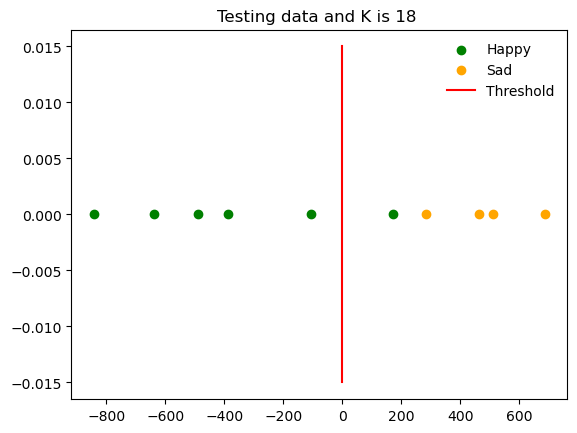

In [20]:
# testing data plotting
yt1_axis = (np.array([0]*(c1.shape[1])))
yt2_axis = (np.array([0]*(c2.shape[1])))
thr_line = np.array([threshold]*5)
y3_axis = np.linspace(-0.015,0.015,5)
plt.scatter(c1,yt1_axis,color='green',label = 'Happy')# Happy
plt.scatter(c2,yt2_axis,color='orange',label = 'Sad')# sad
plt.plot(thr_line,y3_axis,color='red',label = "Threshold")
plt.legend(frameon=False)
plt.title("Testing data and K is 18 ")
plt.savefig("test_"+str(k)+".jpg")

In [17]:
Accuracy(training_data_class,class_train)
print("Actual Label   ",training_data_class) 
print("Predicted label",class_train)

Number of prediction:  20
Number of wrong predictions:  0
Accuracy:  100.0
Actual Label    [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]
Predicted label [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]


In [18]:
Accuracy(testing_data_class,class_test)
print("Actual Label   ",testing_data_class)
print("Predicted label",class_test)

Number of prediction:  10
Number of wrong predictions:  1
Accuracy:  90.0
Actual Label    [0, 1, 1, 1, 0, 1, 1, 0, 1, 0]
Predicted label [0, 1, 1, 0, 0, 1, 1, 0, 1, 0]


In [19]:
JR = FisherRatio(S_b, S_w, W_projector)
print("Fisher ratio is ",JR[0][0])

Fisher ratio is  48.286992416371326
